## IV. Training data and Modeling

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import uniform, randint

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from library.sb_utils import save_file

In [95]:
filepath = '../data/vehicle_data_final.csv'
data = pd.read_csv(filepath)

Let's take a look at our data again

In [96]:
data.head(3)

,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age,log_price
0,chevrolet,corvette grand sport,good,8 cylinders,gas,32742.0,clean,other,rwd,other,other,al,11.0,10.490996
1,hyundai,sonata,excellent,4 cylinders,gas,93600.0,clean,automatic,fwd,sedan,other,al,7.0,8.922658
2,bmw,x3 3.0i,good,6 cylinders,gas,87046.0,clean,automatic,other,SUV,blue,al,15.0,8.496990


In [97]:
data.shape

(382322, 14)

In [98]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382322 entries, 0 to 382321
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   manufacturer  382322 non-null  object 
 1   model         382322 non-null  object 
 2   condition     382322 non-null  object 
 3   cylinders     382322 non-null  object 
 4   fuel          382322 non-null  object 
 5   odometer      382322 non-null  float64
 6   title_status  382322 non-null  object 
 7   transmission  382322 non-null  object 
 8   drive         382322 non-null  object 
 9   type          382322 non-null  object 
 10  paint_color   382322 non-null  object 
 11  state         382322 non-null  object 
 12  age           382322 non-null  float64
 13  log_price     382322 non-null  float64
dtypes: float64(3), object(11)
memory usage: 40.8+ MB


Since we have category columns, we will need to change them to integer to be able to train them. 2 options:
- Dummy Variables
- LabelEncoder

Now, originally I tried to create dummy variables, which will probably gives us a little better model than LabelEncoder, but with the model column contains over 100,000 different name, that will require a massive hardware to build the model with dummy variables. So we will go with LabelEncoder instead.

In [99]:
def label_encoder(column):
    lb = LabelEncoder()
    data[column] = lb.fit_transform(data[column])

In [100]:
columns = ['manufacturer', 'model', 'condition', 'cylinders',
       'fuel', 'title_status', 'transmission', 'drive', 'type',
       'paint_color', 'state']
for column in columns:
    label_encoder(column)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382322 entries, 0 to 382321
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   manufacturer  382322 non-null  int32  
 1   model         382322 non-null  int32  
 2   condition     382322 non-null  int32  
 3   cylinders     382322 non-null  int32  
 4   fuel          382322 non-null  int32  
 5   odometer      382322 non-null  float64
 6   title_status  382322 non-null  int32  
 7   transmission  382322 non-null  int32  
 8   drive         382322 non-null  int32  
 9   type          382322 non-null  int32  
 10  paint_color   382322 non-null  int32  
 11  state         382322 non-null  int32  
 12  age           382322 non-null  float64
 13  log_price     382322 non-null  float64
dtypes: float64(3), int32(11)
memory usage: 24.8 MB


Now let's train the data

## XGBoost

In [104]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('log_price', axis=1), data['log_price'], test_size=0.3, random_state=123)

Let split the train set into 2 set for XGBoost, one to train, and one to validate the model during training

In [160]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=123)

In [105]:
#Create function to get best score parameters
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [161]:
#Create initial model using XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror')

In [107]:
#Search for best params using RandomizedSearchCV
params = {
    "colsample_bytree": [i/10.0 for i in range(6, 10)],
    "gamma": [i/10.0 for i in range(0, 5)],
    "learning_rate": [i/10.0 for i in range(1, 11)], # default 0.1 
    "max_depth": range(1, 10), # default 3
    "subsample": [i/10.0 for i in range(6,10)],
    "min_child_weight": range(1, 6),
}

In [162]:
search = RandomizedSearchCV(xgb_model, param_distributions=params,  random_state=42, n_iter=5, cv=5, verbose=1, n_jobs=-1, return_train_score=True)

search.fit(X_tr, y_tr)

report_best_scores(search.cv_results_, 1)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   57.8s finished


Model with rank: 1
Mean validation score: 0.869 (std: 0.001)
Parameters: {'subsample': 0.7, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.5, 'gamma': 0.3, 'colsample_bytree': 0.6}



In [163]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', subsample=0.7, n_estimators=10000, min_child_weight=2, max_depth=8, 
                             learning_rate=0.5, gamma=0.3, colsample_bytree=0.6)

In [164]:
xgb_model.fit(X_tr, y_tr, early_stopping_rounds=50, verbose=0, eval_set=[(X_val, y_val)])
y_pred_xgb = xgb_model.predict(X_test)

In [165]:
mean_absolute_error(y_test, y_pred_xgb)

0.18211294360291302

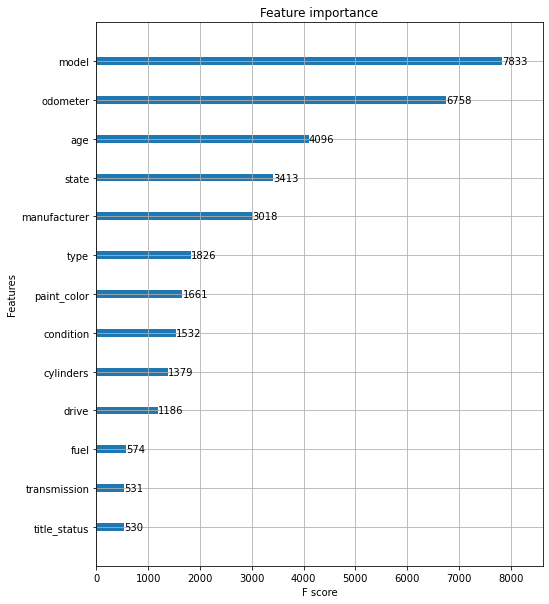

In [166]:
ax = xgb.plot_importance(xgb_model)
fig = ax.figure
fig.set_size_inches(8, 10)

### Ridge Regression

In [115]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    Ridge()
)

In [116]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000020BCF156820>)),
                ('ridge', Ridge())])

In [117]:
y_pred_ridge = pipe.predict(X_test)

In [119]:
mean_absolute_error(y_test, y_pred_ridge)

0.4159839744661408

In [120]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}
gr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)

In [121]:
gr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000020BCF156820>)),
                                       ('ridge', Ridge())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13]})

In [122]:
score_mean = gr_grid_cv.cv_results_['mean_test_score']
score_std = gr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in gr_grid_cv.cv_results_['param_selectkbest__k']]
gr_grid_cv.best_params_

{'selectkbest__k': 13}

In [125]:
pipe13 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=13),
    Ridge()
)

In [126]:
pipe13.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=13,
                             score_func=<function f_regression at 0x0000020BCF156820>)),
                ('ridge', Ridge())])

In [129]:
y_pred_ridge = pipe13.predict(X_test)

In [131]:
mean_absolute_error(y_test, y_pred_ridge)

0.4157713170984109

In [132]:
selected = gr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [133]:
coefs = gr_grid_cv.best_estimator_.named_steps.ridge.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

cylinders       0.145939
transmission    0.052217
paint_color     0.011816
model           0.006639
condition      -0.005203
type           -0.007754
state          -0.013887
manufacturer   -0.014092
title_status   -0.056982
drive          -0.072486
fuel           -0.150984
odometer       -0.216097
age            -0.443420
dtype: float64

### Linear Regression

In [134]:
pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [135]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(score_func=<function f_regression at 0x0000020BCF156820>)),
                ('linearregression', LinearRegression())])

In [136]:
y_pred_lr = pipe.predict(X_test)

In [137]:
mean_absolute_error(y_test, y_pred_lr)

0.4159838438449816

In [138]:
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x0000020BCF156820>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13]})

In [139]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in gr_grid_cv.cv_results_['param_selectkbest__k']]
lr_grid_cv.best_params_

{'selectkbest__k': 13}

In [140]:
pipe13 = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression, k=13),
    LinearRegression()
)

In [141]:
pipe13.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('selectkbest',
                 SelectKBest(k=13,
                             score_func=<function f_regression at 0x0000020BCF156820>)),
                ('linearregression', LinearRegression())])

In [142]:
y_pred_lr = pipe13.predict(X_test)

In [143]:
mean_absolute_error(y_test, y_pred_lr)

0.41577118745936126

In [144]:
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train.columns[selected]
pd.Series(coefs, index=features).sort_values(ascending=False)

cylinders       0.145939
transmission    0.052217
paint_color     0.011816
model           0.006639
condition      -0.005203
type           -0.007754
state          -0.013887
manufacturer   -0.014092
title_status   -0.056982
drive          -0.072486
fuel           -0.150985
odometer       -0.216097
age            -0.443422
dtype: float64

## Choosing Model

So finally, we have the mae of 3 models: XGboost, Ridge Regression and Linear Regression. XGBoost outperforms other models with mae of 0.182, while Ridge and Linear regression are about 0.416.

In [167]:
(r2_score(y_test, y_pred_xgb), r2_score(y_test, y_pred_ridge), r2_score(y_test, y_pred_lr))

(0.8836752427637689, 0.581912475395427, 0.5819124867684591)

XGBoost also has much higher R2 score.

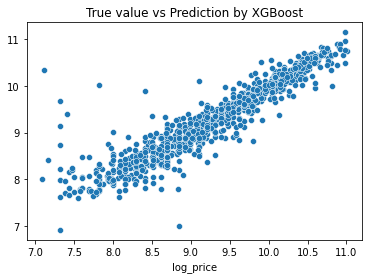

In [146]:
sns.scatterplot(x=y_test[:1000], y=y_pred_xgb[:1000])
plt.title('True value vs Prediction by XGBoost');

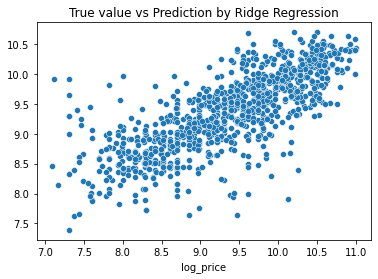

In [147]:
sns.scatterplot(x=y_test[:1000], y=y_pred_ridge[:1000])
plt.title('True value vs Prediction by Ridge Regression');

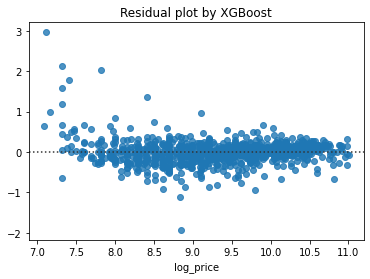

In [149]:
sns.residplot(x=y_test[:1000], y=y_pred_xgb[:1000])
plt.title('Residual plot by XGBoost');

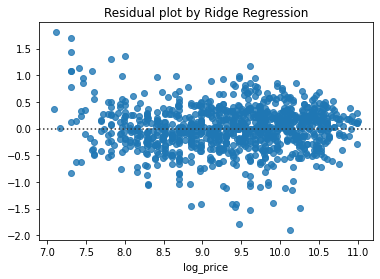

In [150]:
sns.residplot(x=y_test[:1000], y=y_pred_ridge[:1000])
plt.title('Residual plot by Ridge Regression');

Now let's test the model with a sample data. I have a Silver Toyota Prius C 2013, about 30000 miles and has a rebuilt title. 

In [309]:
tit_le.classes_

array(['clean', 'lien', 'missing', 'other', 'parts only', 'rebuilt',
       'salvage'], dtype=object)

In [151]:
my_car = {'state': 4, 
          'model': 18132, 
          'odometer': 30000, 
          'age': 7, 
          'manufacturer': 40 , 
          'type': 4, 
          'paint_color': 10, 
          'condition': 2,
          'cylinders': 3,
          'drive': 1,
          'fuel': 3,
          'transmission': 0,
          'title_status': 5}

In [152]:
data = data.append(my_car, ignore_index=True)

Now rerun the LabelEncoder and get the data prediction

In [153]:
data

,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,age,log_price
0,7.0,8527.0,2.0,6.0,2.0,32742.0,0.0,2.0,3.0,7.0,7.0,1.0,11.0,10.490996
1,18.0,20647.0,0.0,3.0,2.0,93600.0,0.0,0.0,1.0,9.0,7.0,1.0,7.0,8.922658
2,4.0,23500.0,2.0,5.0,2.0,87046.0,0.0,0.0,2.0,0.0,1.0,1.0,15.0,8.496990
3,13.0,12234.0,0.0,6.0,0.0,116000.0,1.0,0.0,0.0,8.0,1.0,1.0,16.0,9.878170
4,40.0,21495.0,2.0,5.0,2.0,33290.0,0.0,2.0,2.0,8.0,9.0,1.0,5.0,10.295192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
382318,18.0,22559.0,0.0,3.0,2.0,31888.0,0.0,0.0,0.0,0.0,11.0,48.0,3.0,9.792277
382319,6.0,8959.0,0.0,5.0,2.0,53000.0,0.0,0.0,0.0,3.0,0.0,50.0,7.0,9.792556
382320,21.0,13717.0,2.0,6.0,2.0,164000.0,0.0,0.0,0.0,0.0,11.0,50.0,13.0,7.170120
382321,32.0,3970.0,5.0,7.0,0.0,164000.0,0.0,0.0,2.0,7.0,7.0,50.0,13.0,10.038892


In [154]:
my_car_test = data[382322:]

In [155]:
my_car_test.drop(columns=['log_price'], inplace=True)

C:\Users\hyuwo\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [156]:
my_car_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 382322 to 382322
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   manufacturer  1 non-null      float64
 1   model         1 non-null      float64
 2   condition     1 non-null      float64
 3   cylinders     1 non-null      float64
 4   fuel          1 non-null      float64
 5   odometer      1 non-null      float64
 6   title_status  1 non-null      float64
 7   transmission  1 non-null      float64
 8   drive         1 non-null      float64
 9   type          1 non-null      float64
 10  paint_color   1 non-null      float64
 11  state         1 non-null      float64
 12  age           1 non-null      float64
dtypes: float64(13)
memory usage: 236.0 bytes


In [157]:
my_car_predict = xgb_model.predict(my_car_test)

In [158]:
my_car_predict

array([9.408829], dtype=float32)

In [159]:
np.exp(my_car_predict)

array([12195.578], dtype=float32)

In [169]:
np.exp(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

1.3326827983944929

Very interesting. The model predict my car would have the value of \$12195 on the market. I think this is a fair prediction, even though I am trying to sell it for 6000, because the model only use listing price to predict, not the sold price, which would be more accurate.

Things to consider:
- Computer cannot handle dummy variables with too many columns
- Title seems not to be big affect to value, this is unexpected. Thought this should be one of the most important features.